In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import pathlib
import shutil

data_dir_path = "mask_yolo"
shutil.unpack_archive(data_dir_path + "/archive.zip", data_dir_path)

data_dir = pathlib.Path(data_dir_path + "/obj/").with_suffix('')

# data_dir = pathlib.Path(data_dir_path) / "obj"


image_files = list(data_dir.glob('*.jpg'))
print(len(image_files))

1510


In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

mask_yolo/obj/masked (1569).jpg


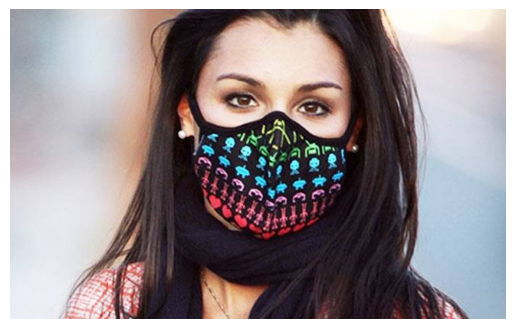

In [3]:
sample_img_path = str(image_files[103])
print(sample_img_path)
sample_img = cv.imread(sample_img_path, cv.IMREAD_COLOR)
plt.imshow(cv.cvtColor(sample_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [4]:
sample_annotation_path = sample_img_path[0:-4] + '.txt'
with open(sample_annotation_path) as f:
    print(f.readlines())

['0 0.5417310664605873 0.4121287128712871 0.37248840803709427 0.6410891089108911\n']


In [5]:
import os, random

def list_files(full_data_path = "mask_yolo/obj/", image_ext = '.jpg', split_percentage = [70, 20]):


    files = []

    discarded = 0
    masked_instance = 0

    for r, d, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(".txt"):

                # first, let's check if there is only one object
                with open(full_data_path + "/" + file, 'r') as fp:
                    lines = fp.readlines()
                    if len(lines) > 1:
                        discarded += 1
                        continue


                strip = file[0:len(file) - len(".txt")]
                # secondly, check if the paired image actually exist
                image_path = full_data_path + "/" + strip + image_ext
                if os.path.isfile(image_path):
                    # checking the class. '0' means masked, '1' for unmasked
                    if lines[0][0] == '0':
                        masked_instance += 1
                    files.append(strip)

    size = len(files)
    print(str(discarded) + " file(s) discarded")
    print(str(size) + " valid case(s)")
    print(str(masked_instance) + " are masked cases")

    random.shuffle(files)

    split_training = int(split_percentage[0] * size / 100)
    split_validation = split_training + int(split_percentage[1] * size / 100)

    return files[0:split_training], files[split_training:split_validation], files[split_validation:]


In [6]:
training_files, validation_files, test_files = list_files()

print(str(len(training_files)) + " training files")
print(str(len(validation_files)) + " validation files")
print(str(len(test_files)) + " test files")

218 file(s) discarded
1292 valid case(s)
832 are masked cases
904 training files
258 validation files
130 test files


In [7]:
input_size = 100

def format_image(img, box):
    height, width = img.shape
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int((x - 0.5*w)* width / r), int((y - 0.5*h) * height / r), int(w*width / r), int(h*height / r)]

    return new_image, new_box

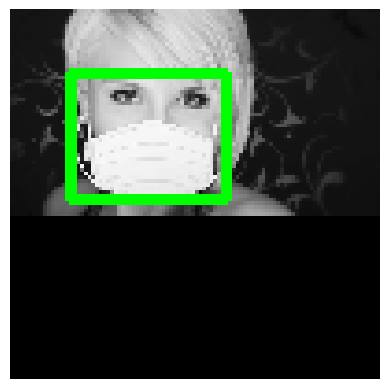

In [8]:
temp_img = cv.imread("mask_yolo/obj/5-with-mask.jpg", cv.IMREAD_GRAYSCALE)
temp_box = [0.38183279742765275, 0.6171428571428571, 0.43569131832797425, 0.6285714285714286]

temp_img_formated, box = format_image(temp_img, temp_box)

temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

cv.rectangle(temp_color_img, box, (0, 255, 0), 2)

plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

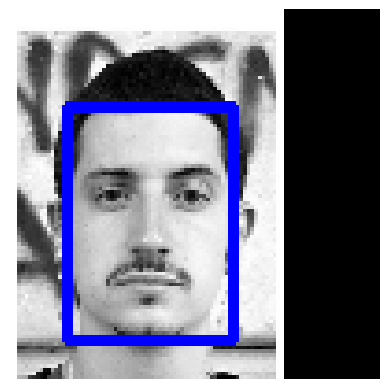

In [9]:
temp_img = cv.imread("mask_yolo/obj/149.jpg", cv.IMREAD_GRAYSCALE)
temp_box = [0.5171875, 0.5911214953271028, 0.621875, 0.6495327102803738]

temp_img_formated, box = format_image(temp_img, temp_box)

temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

cv.rectangle(temp_color_img, box, (0, 0, 255), 2)

plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

In [10]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disabling verbose tf logging

# uncomment the following line if you want to force CPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
print(tf.__version__)

2.13.0


In [11]:
def data_load(files, full_data_path = "mask_yolo/obj/", image_ext = ".jpg"):
    X = []
    Y = []

    for file in files:
        img = cv.imread(os.path.join(full_data_path, file + image_ext), cv.IMREAD_GRAYSCALE)

        k = 1

        with open(full_data_path + "/" + file + ".txt", 'r') as fp:
            line = fp.readlines()[0]
            if line[0] == '0':
                k = 0

            box = np.array(line[1:].split(), dtype=float)

        img, box = format_image(img, box)
        img = img.astype(float) / 255.
        box = np.asarray(box, dtype=float) / input_size
        label = np.append(box, k)

        X.append(img)
        Y.append(label)

    X = np.array(X)

    X = np.expand_dims(X, axis=3)

    X = tf.convert_to_tensor(X, dtype=tf.float32)

    Y = tf.convert_to_tensor(Y, dtype=tf.float32)

    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result

In [12]:
raw_train_ds = data_load(training_files)

In [13]:
raw_validation_ds = data_load(validation_files)

In [14]:
raw_test_ds = data_load(test_files)

In [15]:
print(type(raw_test_ds))

<class 'tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset'>


In [16]:
CLASSES = 2

def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

In [17]:
BATCH_SIZE = 32

# see https://www.tensorflow.org/guide/data_performance

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [18]:
train_ds = tune_training_ds(raw_train_ds)

In [19]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(validation_files) // 4)
    dataset = dataset.repeat()
    return dataset

In [20]:
validation_ds = tune_validation_ds(raw_validation_ds)

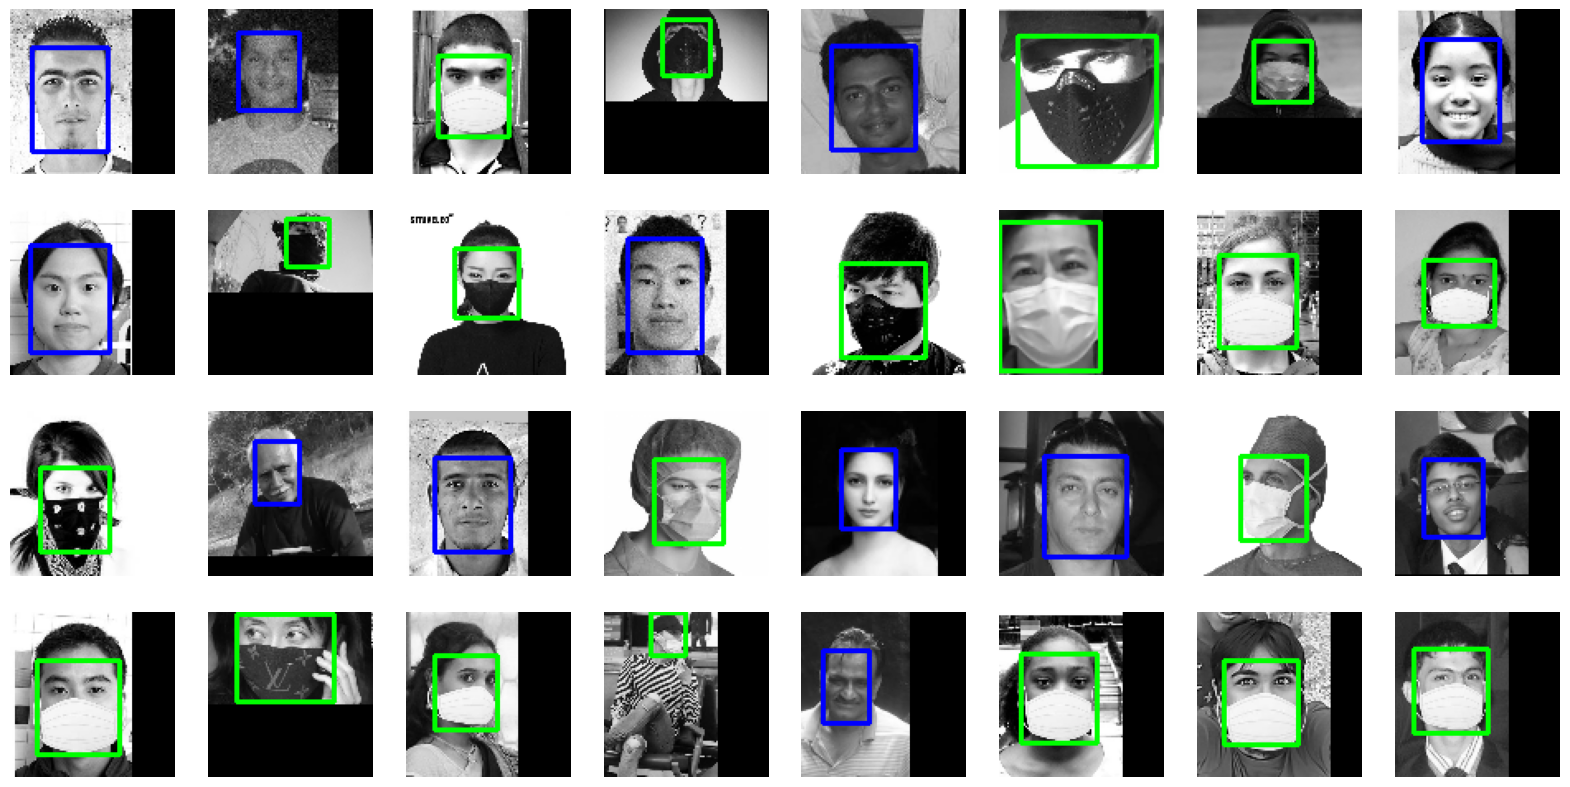

In [21]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
        label = labels[0][i]
        box = (labels[1][i] * input_size)
        box = tf.cast(box, tf.int32)

        image = images[i].numpy().astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        color = (0, 0, 255)
        if label[0] > 0:
            color = (0, 255, 0)

        cv.rectangle(image_color, box.numpy(), color, 2)

        plt.imshow(image_color)
        plt.axis("off")

In [24]:
DROPOUT_FACTOR = 0.5

def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu' ,input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)
    x = tf.keras.layers.MaxPooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation = 'relu')(x)

    return x

def build_model_adaptor(inputs):
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(20, activation='relu')(x)
  return x

def build_classifier_head(inputs):
  return tf.keras.layers.Dense(CLASSES, activation='sigmoid', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units = '4', name = 'regressor_head')(inputs)

def build_model(inputs):

    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' },
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model

In [25]:
model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100, 100, 1)]        0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 98, 98, 64)           640       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 49, 49, 64)           0         ['conv2d_2[0][0]']            
 g2D)                                                                                             
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 64)           0         ['max_pooling2d_1[0][0]'

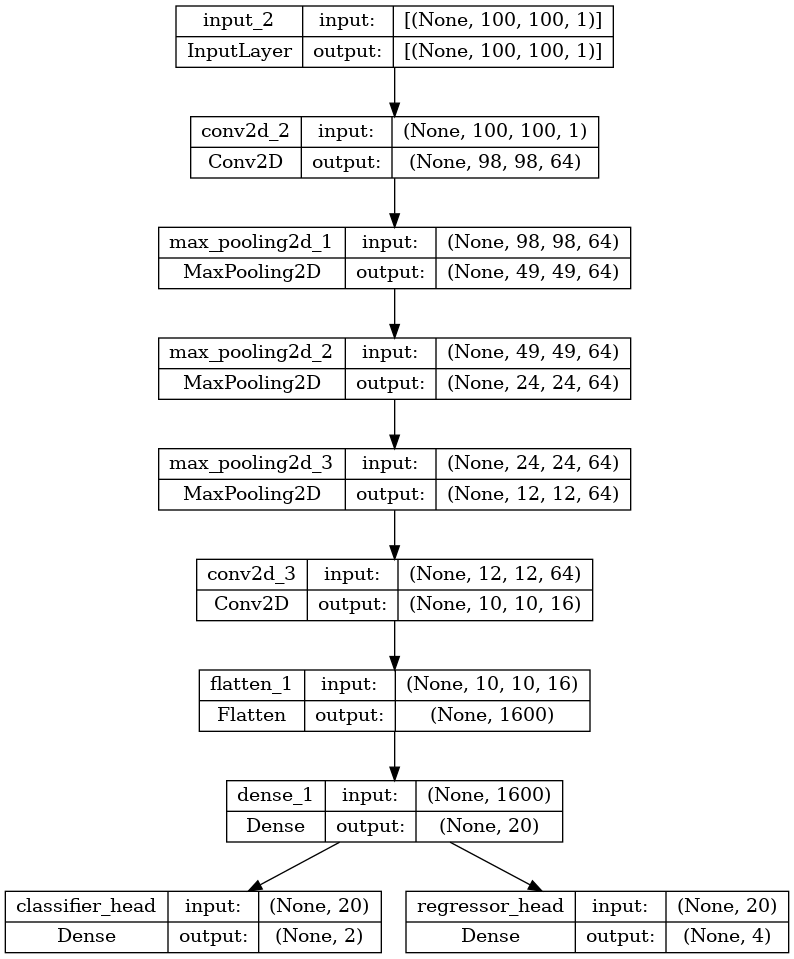

In [26]:
# plot_model requires graphviz & pydot
# see https://github.com/XifengGuo/CapsNet-Keras/issues/7#issuecomment-370745440
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [27]:
EPOCHS = 1

history = model.fit(train_ds,
                    steps_per_epoch=(len(training_files) // BATCH_SIZE),
                    validation_data=validation_ds, validation_steps=1,
                    epochs=EPOCHS,
                    verbose=1)


28/28 [==============================] - 5s 152ms/step - loss: 0.6426 - classifier_head_loss: 0.5996 - regressor_head_loss: 0.0430 - classifier_head_accuracy: 0.6562 - regressor_head_mse: 0.0430 - val_loss: 0.6611 - val_classifier_head_loss: 0.6426 - val_regressor_head_loss: 0.0186 - val_classifier_head_accuracy: 0.5781 - val_regressor_head_mse: 0.0186


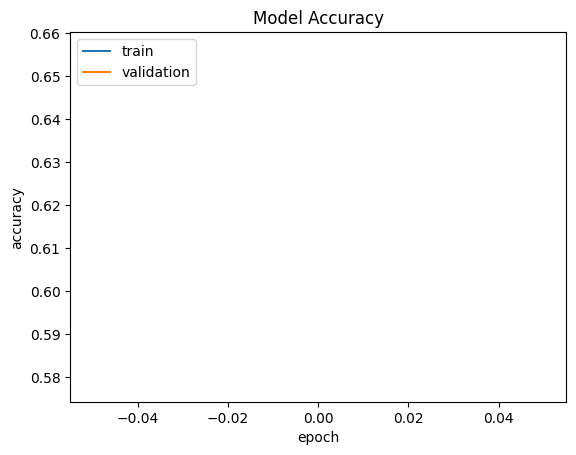

In [28]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

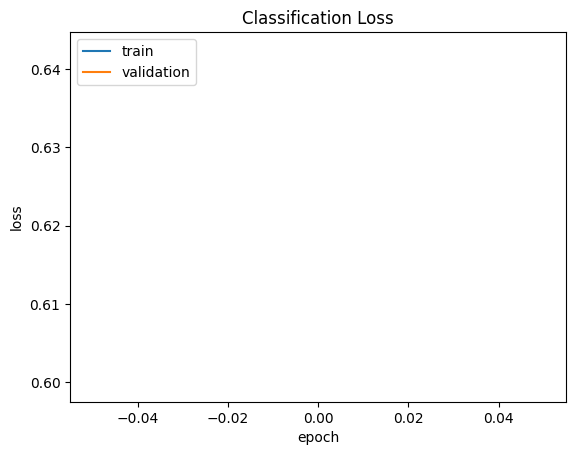

In [29]:
plt.plot(history.history['classifier_head_loss'])
plt.plot(history.history['val_classifier_head_loss'])
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

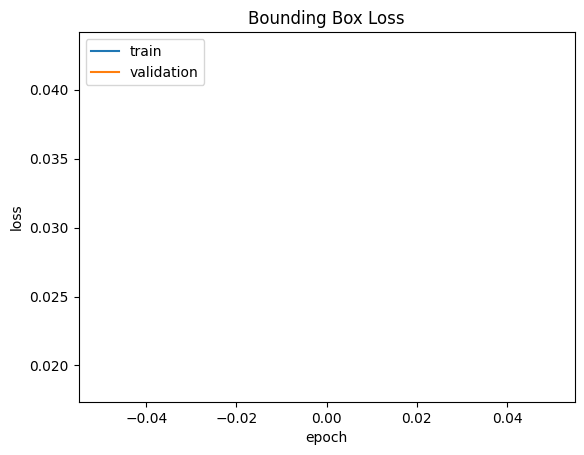

In [30]:
plt.plot(history.history['regressor_head_loss'])
plt.plot(history.history['val_regressor_head_loss'])
plt.title('Bounding Box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [31]:
# adapted from: https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def intersection_over_union(boxA, boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
	yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
	boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
	iou = interArea / float(boxAArea + boxBArea - interArea)
	return iou

In [32]:
def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1)
    dataset = dataset.repeat()
    return dataset

test_ds = tune_test_ds(raw_test_ds)

20


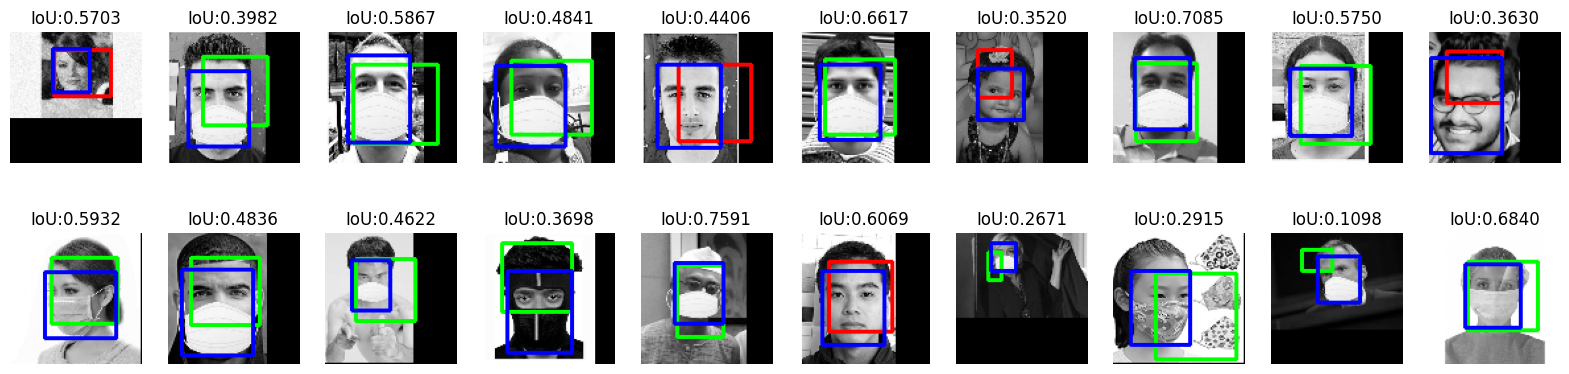

In [33]:
plt.figure(figsize=(20, 10))

test_list = list(test_ds.take(20).as_numpy_iterator())

print(len(test_list))

image, labels = test_list[0]

for i in range(len(test_list)):

    ax = plt.subplot(4, 10, i + 1)
    image, labels = test_list[i]

    predictions = model(image)

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)

    predicted_label = predictions[0][0]

    image = image[0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    color = (255, 0, 0)
    # print box red if predicted and actual label do not match
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0)

    cv.rectangle(image_color, predicted_box.numpy(), color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")

In [34]:
model.save_weights('mask_yolo/model_weights.h5')

In [35]:
print(model.trainable_variables)

[<tf.Variable 'conv2d_2/kernel:0' shape=(3, 3, 1, 64) dtype=float32, numpy=
array([[[[-0.0457408 , -0.02433823,  0.07693625, -0.06213366,
           0.02058935, -0.02683916, -0.01686366,  0.02244384,
          -0.07317335, -0.01373111, -0.04881022,  0.06209669,
          -0.05222423, -0.06937385,  0.05258633, -0.04032075,
           0.003862  , -0.08520576, -0.02290397,  0.08532052,
           0.0123375 , -0.05834271,  0.07860092,  0.06448702,
           0.07471556,  0.00663793, -0.0918185 ,  0.00870299,
           0.07763714, -0.05723248, -0.07232387, -0.07165793,
           0.07718543,  0.06057594,  0.04377914, -0.07358619,
          -0.05655408,  0.02324498,  0.08674771, -0.01980195,
           0.04676749,  0.06272478, -0.01226107, -0.01964876,
          -0.04317917,  0.01228794, -0.06351423,  0.07007907,
          -0.03945636,  0.08919061,  0.0823618 , -0.06340019,
          -0.08281372, -0.03710623, -0.02149625,  0.04520432,
          -0.04598954, -0.08410343,  0.08306225,  0.0133

In [35]:
# image, labels = test_list[0]
# print(image.shape)
# print(image)
# for i in range(image.shape[0]):
#   for j in range(image.shape[0]):
#     print(image[i][j])

# print(type(image))

In [36]:
# def get_activations(model, inputs):
#     layer_outputs = [layer.output for layer in model.layers]
#     activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
#     activations = activation_model.predict(inputs)
#     return activations

# # Perform inference and get activations
# activations = get_activations(model, image)

In [37]:
# for i, activation in enumerate(activations):
#     print(f"Layer {i}: {activation.shape}:  {activation}")

20
[<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.8240018, 0.6950701]], dtype=float32)>, <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.21980368, 0.22488827, 0.6273965 , 0.57537794]], dtype=float32)>]
predicted_label: tf.Tensor([0.8240018 0.6950701], shape=(2,), dtype=float32)


(-0.5, 99.5, 99.5, -0.5)

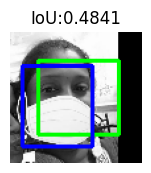

In [37]:
plt.figure(figsize=(20, 10))

test_list = list(test_ds.take(20).as_numpy_iterator())

print(len(test_list))

image, labels = test_list[3]



ax = plt.subplot(4, 10, i + 1)
image, labels = test_list[3]

predictions = model(image)
print(predictions)

predicted_box = predictions[1][0] * input_size
predicted_box = tf.cast(predicted_box, tf.int32)

predicted_label = predictions[0][0]

print("predicted_label:", predicted_label)

image = image[0]

actual_label = labels[0][0]
actual_box = labels[1][0] * input_size
actual_box = tf.cast(actual_box, tf.int32)

image = image.astype("float") * 255.0
image = image.astype(np.uint8)
image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

color = (255, 0, 0)
# print box red if predicted and actual label do not match
if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
    color = (0, 255, 0)

cv.rectangle(image_color, predicted_box.numpy(), color, 2)
cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)

IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

plt.title("IoU:" + format(IoU, '.4f'))
plt.imshow(image_color)
plt.axis("off")

In [59]:
import tensorflow as tf
import numpy as np
import cv2

In [68]:
image_path = 'mask_yolo/mask.jpeg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
nimage = cv2.resize(image, (100,100))
nimage = nimage.astype(np.float32)
nimage /= 255.0
image = nimage.reshape((1, 100, 100, 1))

In [69]:
print(image.shape)

(1, 100, 100, 1)


In [70]:
# for i in range(image1.shape[0]):
#     for j in range(image1.shape[1]):
#         for k in range(image1.shape[2]):
#             for l in range(image1.shape[3]):
#                 print(image1[i][j][k][l])

In [71]:
%%time
classification_pred, regression_pred = model.predict(image)

1/1 [==============================] - 0s 44ms/step
CPU times: user 75 ms, sys: 5.32 ms, total: 80.3 ms
Wall time: 74.6 ms


In [72]:
print("Classification predictions:", classification_pred)
print("Regression predictions:", regression_pred)

Classification predictions: [[0.88094527 0.5402472 ]]
Regression predictions: [[0.3074053  0.16525228 0.5602969  0.5150151 ]]


In [73]:
def get_activations(model, inputs):
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(inputs)
    return activations

# Perform inference and get activations
activations = get_activations(model, image1)

1/1 [==============================] - 0s 53ms/step


In [74]:
for i, activation in enumerate(activations):
    print(f"Layer {i}: {activation.shape}:  {activation}")

Layer 0: (1, 100, 100, 1):  [[[[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  ...

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]]]
Layer 1: (1, 98, 98, 64):  [[[[0.04766744 0.         0.20575897 ... 0.         0.02240975
    0.19035089]
   [0.04766744 0.         0.20575897 ... 0.         0.02240975
    0.19035089]
   [0.04766744 0.         0.20575897 ... 0.         0.02240975
    0.19035089]
   ...
   [0.04649354 0.         0.2058013  ... 0.         0.02117941
    0.1887403 ]
   [0.04766744 0.         0.20575897 ... 0.         0.02240975
    0.19035089]
   [0.04766744 0.         0.20575897 ... 0.         0.02240975
    0.19035089]]

  [[0.04766744 0.         0.20575897 ... 0.         0.02240975
    0.19035089]
   [0.04766744 0.         0.20575

1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.88094527 0.5402472 ] [0.3074053  0.16525228 0.5602969  0.5150151 ]
[0.88094527 0.5402472 ]
tf.Tensor([30 16 56 51], shape=(4,), dtype=int32)


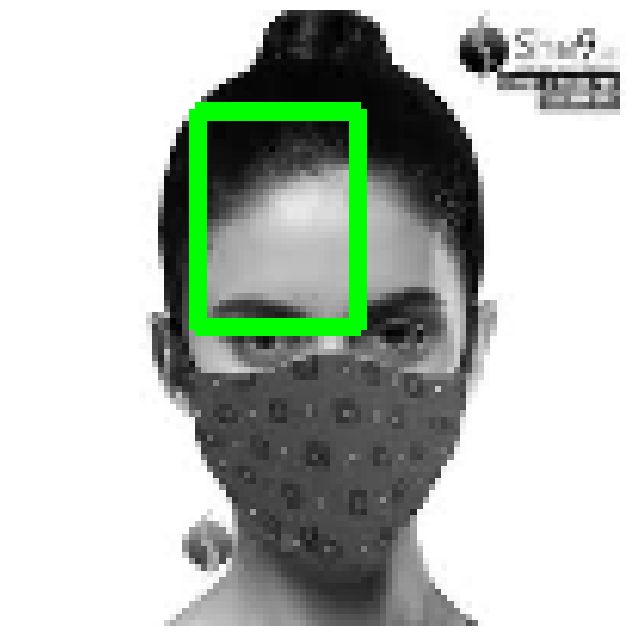

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

# Load the image
image_path = 'mask_yolo/mask.jpeg'
image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

# Preprocess the image (resize, normalize, etc.) to match the input size expected by your model
# Assuming 'input_size' is defined somewhere in your code
image = cv.resize(image, (input_size, input_size))
image = image.astype(np.float32) / 255.0  # Normalize the pixel values

# Expand dimensions to match the shape expected by the model
image_input = np.expand_dims(image, axis=0)
image_input = np.expand_dims(image_input, axis=-1)

# Make predictions
predictions = model.predict(image_input)

# Extract predicted label and box
predicted_label = predictions[0][0]
print("Hello:", predicted_label,predictions[1][0] )
predicted_box = predictions[1][0] * input_size
predicted_box = tf.cast(predicted_box, tf.int32)

# Assuming 'intersection_over_union' function is defined somewhere in your code
IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

# Convert grayscale image to RGB for visualization
image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

# Draw predicted bounding box
color = (0, 255, 0)  # Green color
print(predicted_label)

x1, y1, x2, y2 = predicted_box

print(predicted_box)

predicted_box = predicted_box.numpy()  # Convert to numpy array
x1, y1, x2, y2 = predicted_box

# Draw rectangle
cv.rectangle(image_color, (x1, y1), (x2, y2), color, 2)

# Display the image with the predicted bounding box
plt.figure(figsize=(8, 8))
plt.imshow(image_color)
plt.axis("off")
plt.show()
